# Risk assessment for heavy snowfall & blizzards

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_2.ipynb) to launch this workflow on MyBinder. 

This is the first and simplest snow workflow.  

## Preparation work

### Select area of interest
Before accessing the data, we will define the area of interest. Before commencing this workflow, you should have already prepared by downloading the heavy snowfall and blizzards hazard map to your local directory (using the SNOW hazard workflow for heavy snowfall and blizzards or by using your own data). Please specify the name of the area for the snow hazard maps below.

In [1]:
areaname = 'Europe'

### Load libraries

In this notebook we will use the following Python libraries:
- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [cdsapi](https://pypi.org/project/cdsapi/) - To access the  CDS data
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pathlib](https://docs.python.org/3/library/pathlib.html) - To create Object-oriented filesystem paths
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [urllib](https://docs.python.org/3/library/urllib.html) - package for working with URLs
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [xclim](https://xclim.readthedocs.io/en/stable/installation.html) - To correct the required data units
- [xesmf](https://xesmf.readthedocs.io/en/stable/) - Universal regridder for geospatial data
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [np](https://numpy.org) - Numerical computing tools  
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps



In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import cdsapi
import os
from pathlib import Path
import pooch
from urllib.request import urlopen

import xarray as xr
import xclim as xc
import xesmf as xe
import rioxarray as rxr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

##  Create the directory structure 

In order for this workflow to work even if you download and use just this notebook, we need to have the directory structure for accessing and storing data. If you have already executed the hazard assessment workflow for snow, you would already have created the workflow folder 'SNOW_hazard' where the hazard data is stored. We create an additional folder for the risk workflow, called 'SNOW_risk'.


In [3]:
workflow_folder = 'SNOW_hazard'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
if not os.path.exists(general_data_folder):
    os.makedirs(general_data_folder)

In [4]:
data_dir = os.path.join(workflow_folder,f'data_{areaname}')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

plot_dir = os.path.join(workflow_folder,f'plots_{areaname}')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Download and explore the data

### Hazard data - intense snowfall and blizzards maps

As default option, we use the intense snowfall and blizzards maps from the [ERA5 single level dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview), that were downloaded using the hazard assessment workflow for snow.
Below we load the maps and visualize them to check the contents.



In [14]:
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean.nc')
BdayCount_anaProb_mean = xr.open_dataset(BdayCount_anaProb_mean_path)
BdayCount_anaProb_mean

snow6Prob_annual_mean_path = os.path.join(data_dir,f'snow6Prob_annual_mean.nc')
snow6Prob_annual_mean = xr.open_dataset(snow6Prob_annual_mean_path)
snow6Prob_annual_mean

snow25Prob_annual_mean_path = os.path.join(data_dir,f'snow25Prob_annual_mean.nc')
snow25Prob_annual_mean = xr.open_dataset(snow25Prob_annual_mean_path)
snow25Prob_annual_mean


<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 241)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
Data variables:
    snow_days  (latitude, longitude) float64 ...

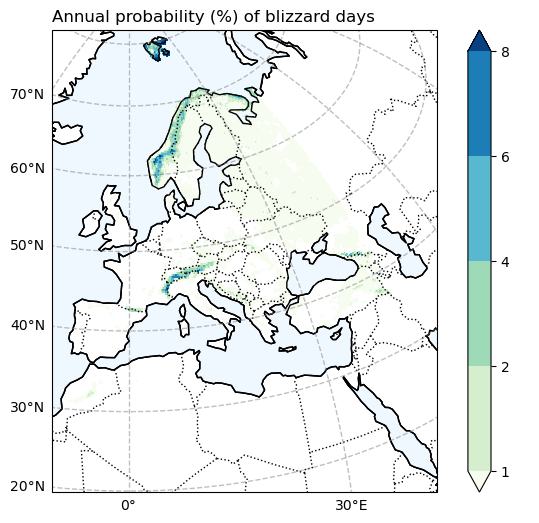

In [6]:
np.warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(8, 6))
p_levels = [ 1,2,4, 6,8]

p = BdayCount_anaProb_mean.blizzard_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels, 
    cbar_kwargs={"label": "  "},
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title('Annual probability (%) of blizzard days', loc = "left")

# Add coastlines and features

p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fileout = os.path.join(plot_dir,'Annual_probability_of_blizzard_days.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

### Exposure - Population data

In this illustration, we are using population data sourced from the JRC data portal, specifically the Global Human Settlement Layer [Global Human Settlement Layer GHSL](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop), with 30 arcsec resolution global datasets. After downloading and extracting the data, Pooch will list the contents within the data directory. 

In [7]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2015_GLOBE_R2023A_4326_30ss/V1-0/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip'
pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    processor=pooch.Unzip(extract_dir=''))


['/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/.DS_Store',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/GHSL_Data_Package_2023.pdf',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/GHS_POP_GLOBE_R2023A_input_metadata.xlsx',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/3f1ff4bbec190dc119ca69ea4a78081a-GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/snow6Prob_annual_mean.nc',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/snow25Prob_annual_mean.nc',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif.ovr',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/SNOW_hazard/data_Europe/BdayCount_AnaProb_mean.nc']

The zip file contains data, as well as metadata and the documentation in the pdf file.

## Explore the data

### Population data

Population data is in file with filename: **GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif**

We can use rioxarray to load this file and explore the projections of the dataset.

In [8]:
filename_population = f'{data_dir}/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif'

population = rxr.open_rasterio(filename_population)
population

population = population.rename({'x': 'longitude','y': 'latitude'})
population.rio.crs

CRS.from_epsg(4326)

Note that now, we have a directory **snow_workflow/data** where all the zip files and unzipped files are stored.

We can list all the files in the **data_dir** using the **os** library.  

In [9]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

.DS_Store
GHSL_Data_Package_2023.pdf
GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif
GHS_POP_GLOBE_R2023A_input_metadata.xlsx
3f1ff4bbec190dc119ca69ea4a78081a-GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip
snow6Prob_annual_mean.nc
snow25Prob_annual_mean.nc
GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif.ovr
BdayCount_AnaProb_mean.nc


## Process the data
###  population data

In this workflow, we want to overlay the population data on snowfall and blizzard indicators to better understand where these indicators affect densely populated areas. 

Take a closer look at the dimensions and coordinates of our two data objects. 
- Notice that the population data has **x** and **y** as spatial dimensions, while ERA5 has **latitude** and **longitude**. 
- Both datasets are in the same projection: **WSG84/epsg 4326**. 
- However, the resolutions of the datasets are different. 

To be able to plot these two datasets together, we must have them at the same resolution and zoomed in to the same area

**regrid the population data** 

We utilize the xESMF library, a Universal Regridder for Geospatial Data, to regrid the population data to match the ERA5 resolution. Prior to regridding, the population data is cropped specifically for the European region.

In [10]:
Europe_population = population.sel(latitude=slice(80.0,20.0), longitude=slice(-10.0,45.0))

snow6Prob_annual_mean.rio.crs
snow6Prob_annual_mean.rio.write_crs(4326, inplace=True)

regridder = xe.Regridder(Europe_population, snow6Prob_annual_mean, 'bilinear', periodic=True)
 
Europe_population_025deg = regridder(Europe_population)

Europe_population_025deg.to_netcdf(path=os.path.join(data_dir, "Europe_population_25deg.nc"))

## Plot the results
### Select the area of interest
We are currently selecting the Alpine region because pollution density is higher in this area, and there is also a greater probability of heavy snow and blizzards, using the specified latitude and longitude extents, which can be modified as needed.


In [26]:
xmin=4  # Min Longitude 
xmax=15 # Max Longitude 

ymin=42 # Min Latitude 
ymax=50 # Max Latitude 

SelArea_population = Europe_population_025deg.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))

SelArea_6cm_ind = snow6Prob_annual_mean.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_25cm_ind = snow25Prob_annual_mean.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_blizard_ind = BdayCount_anaProb_mean.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))



### To explore the exposure and vulnerability of the population, plot them together

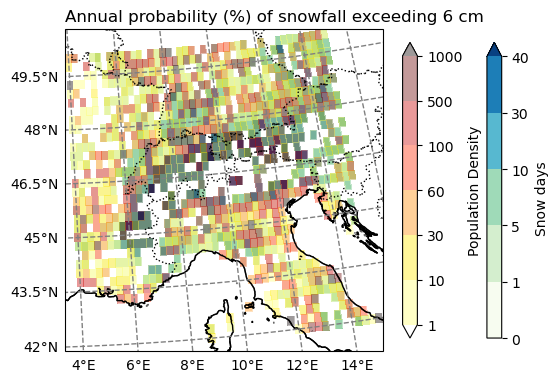

In [37]:
#del SelArea_population['band']
#del SelArea_population['spatial_ref']

# Create a mask for snow data where pollution density is below 1
snow_data_masked = SelArea_6cm_ind.snow_days.where(SelArea_population >= 1)

# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [0, 1, 5, 10, 30, 40]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

snow_data_masked.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Snow days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of snowfall exceeding 6 cm', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density on the same subplot
mesh = SelArea_population.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4
)

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_of_blizzard_days.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

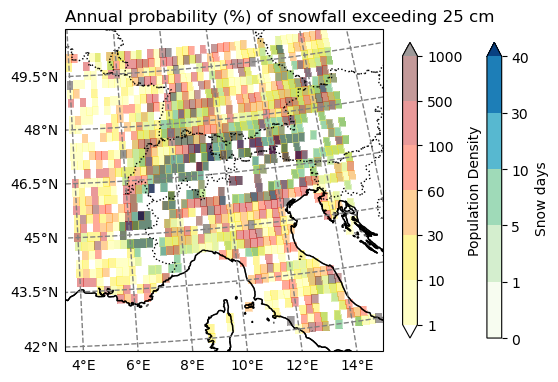

In [41]:
# Create a mask for snow data where pollution density is below 1
snow_data_masked = SelArea_25cm_ind.snow_days.where(SelArea_population >= 1)

# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [0, 1, 5, 10, 30, 40]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

snow_data_masked.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Snow days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of snowfall exceeding 25 cm', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density on the same subplot
mesh = SelArea_population.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4
)

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_of_snowfall_exceeding_25cm.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

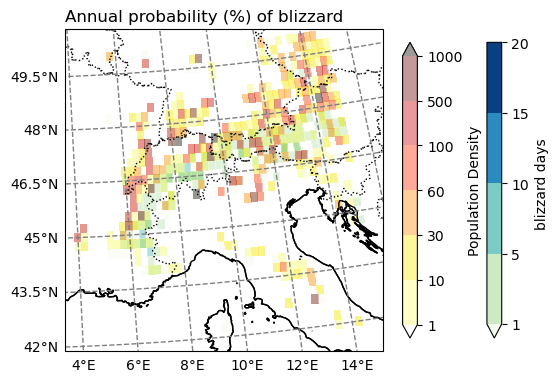

In [40]:
# Create a mask for snow data where pollution density is below 1
snow_data_masked = SelArea_blizard_ind.blizzard_days.where(SelArea_population > 0)

population_masked = SelArea_population.where(SelArea_blizard_ind.blizzard_days > 0)

# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [ 1,5,10,15,20]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

snow_data_masked.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "blizzard days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of blizzard', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density on the same subplot
mesh = population_masked.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4
)
fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_of_snowfall_exceeding_6cm.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

## Conclusions
In this workflow, we've illustrated the process of exploring, processing, and visualizing data necessary for analyzing the influence of heavy snowfall and blizzard day indices on population density. These indices are presented as annual probabilities of occurrence, reflecting the likelihood of a particular event happening over several years. In the present climate, communities in the northern Alpine region face heightened vulnerability to heavy snowfall and blizzards.

## Contributors
Suraj Polade, Finnish Meteorological Institute

Andrea Vajda, Finnish Meteorological Institute